### Training a Sarcasm Detection Model using a Convolution Layer

In [1]:
#importing libraries

import json
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
filepath="D:\\Tensorflow_Works\\8-Sentiment_in_Text\\sarcasm.json"

with open(filepath, "r") as file:
    data = json.load(file)

data[0]    

{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
 'is_sarcastic': 0}

In [3]:
sentences = []
labels = []

for item in data:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

    

In [4]:
#setting parameters to easily tweak them when needed

#number of examples to use for training
training_size = 20000

#vocabulary size of tokenizer
vocab_size=10000

#maximum length of the padded sequences
max_length = 32

#output dimensions of the embedding layer
embedding_dims = 16

In [5]:
#splitting data into train and test splits
train_sentences = sentences[: training_size]
test_sentences = sentences[training_size:]

train_labels = labels[:training_size]
test_labels = labels[training_size:]

In [6]:
#defining vectorize layer

vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)

# generating vocabulary for training sentences
vectorize_layer.adapt(train_sentences)

In [7]:
#preprocess the train and test data

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels))

In [8]:
#defining preprocessing function

def preprocessing_func(dataset):

    dataset_sequences = dataset.map(lambda review, label: (vectorize_layer(review), label))

    dataset_sequences = dataset_sequences.ragged_batch(batch_size=dataset_sequences.cardinality())

    sequences, labels = dataset_sequences.get_single_element()

    padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(), padding="pre", truncating="post", maxlen=max_length)

    padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

    labels = tf.data.Dataset.from_tensor_slices(labels)

    dataset_vectorized = tf.data.Dataset.zip(padded_sequences, labels)

    return dataset_vectorized


In [9]:
#preprocessing train and test datasets

train_dataset_vectorized = train_dataset.apply(preprocessing_func)
test_dataset_vectorized = test_dataset.apply(preprocessing_func)

In [10]:
#viewing 2 example sequences and its labels

for example in train_dataset_vectorized.take(2):
    print(example)
    print()

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  319,    1,
        943, 4079, 2366,   47,  366,   94, 2026,    6, 2653, 9470],
      dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    4, 7185, 3128, 3305,
         28,    2,  152,    1,  358, 2902,    6,  236,    9,  844],
      dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)



In [11]:
#optimizing datasets for training
shuffle_buffer_size = 1000
prefetch_buffer_size = tf.data.AUTOTUNE

train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(shuffle_buffer_size)
                       .batch(32)
                       .prefetch(prefetch_buffer_size))

test_dataset_final = (test_dataset_vectorized
                       .cache()
                       .shuffle(shuffle_buffer_size)
                       .batch(32)
                       .prefetch(prefetch_buffer_size))



In [12]:
# Parameters
EMBEDDING_DIM = 16
FILTERS = 128
KERNEL_SIZE = 5
DENSE_DIM = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.Input(shape=(max_length,)),
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Conv1D(FILTERS, KERNEL_SIZE, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 32, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 28, 128)        │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           774 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,149 (668.55 KB)

 Trainable params: 171,149 (668.55 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
#model training

history = model_conv.fit(train_dataset_final, epochs = 10, validation_data= test_dataset_final)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7663 - loss: 0.4495 - val_accuracy: 0.8469 - val_loss: 0.3495
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9018 - loss: 0.2418 - val_accuracy: 0.8444 - val_loss: 0.3754
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9413 - loss: 0.1595 - val_accuracy: 0.8444 - val_loss: 0.4497
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9683 - loss: 0.0986 - val_accuracy: 0.8389 - val_loss: 0.5473
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9868 - loss: 0.0494 - val_accuracy: 0.8386 - val_loss: 0.6432
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9945 - loss: 0.0236 - val_accuracy: 0.8329 - val_loss: 0.7464
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9981 - loss: 0.0104 - val_accuracy: 0.8323 - val_loss: 0.8269
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9991 - loss: 0.0052 - val_accuracy: 0.

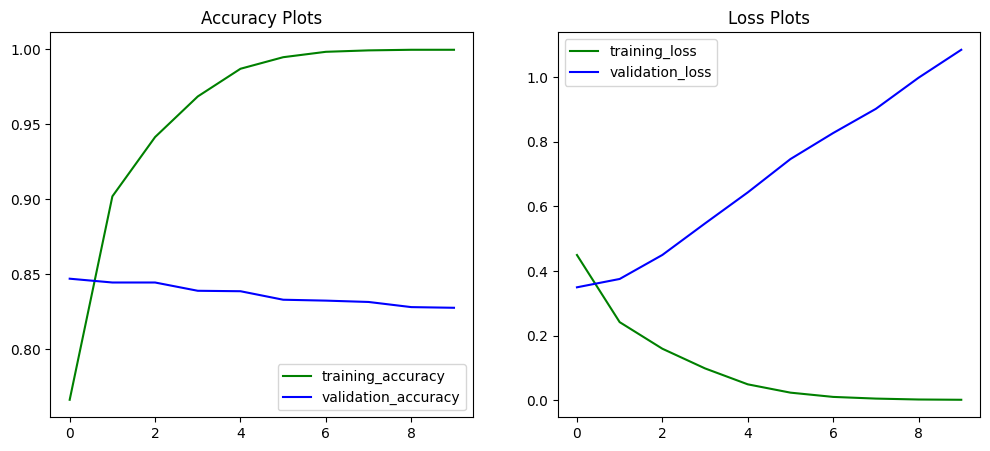

In [14]:
def visualize(history):

    plt.subplots(1,2,figsize=(12,5))
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))

    plt.subplot(1,2,1)
    plt.plot(epochs, accuracy, "g", label="training_accuracy")
    plt.plot(epochs, val_accuracy, 'b', label="validation_accuracy")
    plt.title("Accuracy Plots")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, "g", label="training_loss")
    plt.plot(epochs, val_loss, 'b', label="validation_loss")
    plt.title("Loss Plots")
    plt.legend()


visualize(history)